### Simulating a magnet using a Monte Carlo algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

## 1. Generate starting configuration

We start with a randomly generated array of magnetic moments $ \{ \vec{m}_1, \vec{m}_2, \dots, \vec{m}_n \} $. The length of each moment is fixed $ |\vec{m}_i| = 1 $ but the orientation is chosen randomly. We can construct this by generating a random polar angle $ \varphi_i $ and azimutal angle $ \theta_i $ and using spherical coordinates:

$ \vec{m}_i = \begin{pmatrix} \cos\varphi_i\sin\theta_i \\ \sin\varphi_i\sin\theta_i \\ \cos\theta_i \end{pmatrix} $

### Magnetic moments

In [ ]:
def generate_magnetic_moments(N):
    # Generate a random magnetic moment vector for each particle
    phi = np.random.uniform(0, 2 * np.pi, N)
    cos_theta = np.random.uniform(-1, 1, N)
    theta = np.arccos(cos_theta)
    
    # Convert spherical coordinates to cartesian coordinates
    m_x = np.sin(theta) * np.cos(phi)
    m_y = np.sin(theta) * np.sin(phi)
    m_z = np.cos(theta)
    
    return m_x, m_y, m_z, phi, theta

def plot_moments(m_x, m_y, m_z, phi, theta):
    fig = plt.figure(figsize= (12, 6))
    # 3D plot for cartesian coordinates
    ax1 = fig.add_subplot(121, projection= '3d')
    ax1.quiver(0, 0, 0, m_x, m_y, m_z, length=0.1, normalize=True, color='b')
    ax1.set_title('Magnetic Moments in Cartesian Coordinates')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([-1, 1])
    ax1.set_zlim([-1, 1])
    ax1.set_box_aspect([1, 1, 1])  # Equal aspect ratio

    # 2D plot for Spherical coordinates (projected onto the XY plane)
    ax2 = fig.add_subplot(122, polar=True)
    ax2.set_title('Magnetic Moments in Spherical Coordinates (Projection)')
    ax2.quiver(phi, np.ones_like(phi), angles='xy', scale_units='xy', scale=1, color='r')
    ax2.set_ylim(0, 1)
    ax2.set_xticks(np.linspace(0, 2 * np.pi, 8, endpoint=False))  # Set angular ticks
    plt.tight_layout()
    plt.show()


### Positions

In [3]:
N = 100
m_x, m_y, m_z, phi, theta = generate_magnetic_moments(N)

### Plot

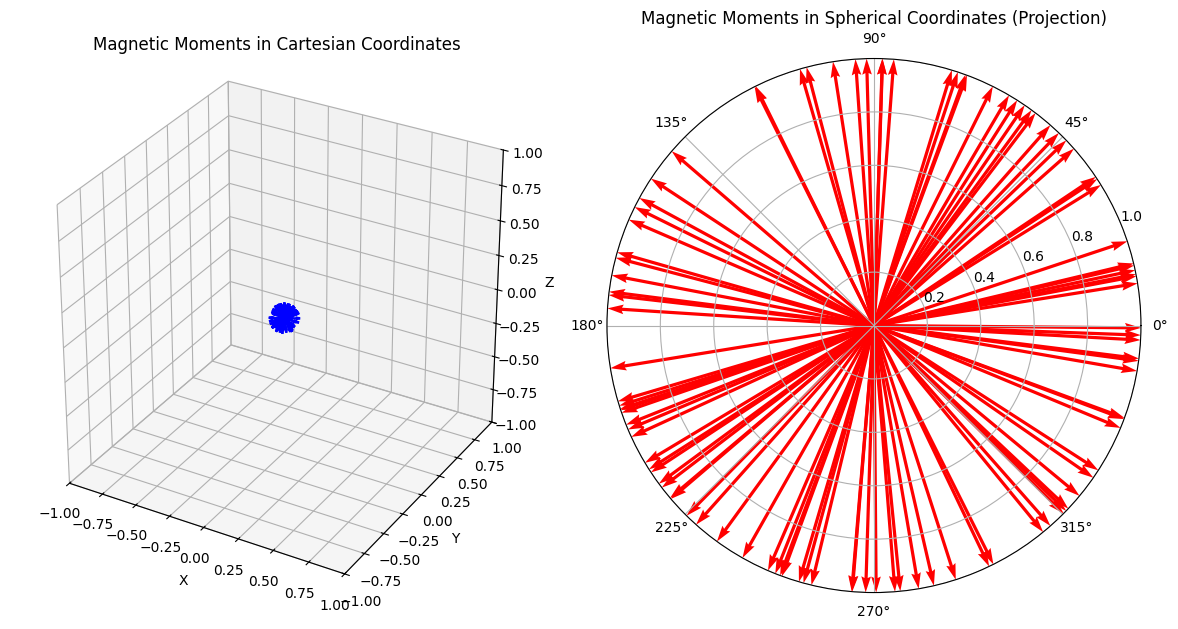

In [4]:
plot_moments(m_x, m_y, m_z, phi, theta)

## 2. Calculating the energy 

We are searching for the configuration with the lowest energy. For a ferromagnet the energy can be written as:

$ H = -\frac{1}{2}J\sum_{<i,j>}\vec{m}_i\cdot\vec{m}_j  $ 

Every moment is interacting with its direct neighbor $( <i,j> )$ and prefers a parallel orientation as long as $ J > 0$. Of course, there exist additional energy terms that have to be considered for a realistic ferromagnet but we will neglect them for now. 

In [5]:
def generate_magnetic_moments(N):
    # Generate a random magnetic moment vector for each particle
    phi = np.random.uniform(0, 2 * np.pi, N)
    cos_theta = np.random.uniform(-1, 1, N)
    theta = np.arccos(cos_theta)
    
    # Convert spherical coordinates to cartesian coordinates
    m_x = np.sin(theta) * np.cos(phi)
    m_y = np.sin(theta) * np.sin(phi)
    m_z = np.cos(theta)
    
    return np.column_stack((m_x, m_y, m_z))

def calculate_energy_3d(magnetic_moments, L, J=1):
    """
    Calculate the total energy of a 3D lattice of magnetic moments.
    
    Parameters:
    - magnetic_moments: Array of shape (L^3, 3) containing magnetic moment vectors.
    - L: Lattice size (cube dimension).
    - J: Exchange interaction constant (default is 1).
    
    Returns:
    - Total energy of the system.
    """
    N = L ** 3
    energy = 0.0
    
    # Reshape magnetic moments into a 3D lattice
    lattice = magnetic_moments.reshape((L, L, L, 3))
    
    # Loop over all lattice sites
    for x in range(L):
        for y in range(L):
            for z in range(L):
                # Current moment
                m_i = lattice[x, y, z]
                
                # Sum interactions with 6 neighbors
                for dx, dy, dz in [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]:
                    # Neighbor coordinates
                    xn, yn, zn = x + dx, y + dy, z + dz
                    
                    # Periodic boundary conditions
                    xn %= L
                    yn %= L
                    zn %= L
                    
                    # Neighbor moment
                    m_j = lattice[xn, yn, zn]
                    
                    # Dot product
                    energy += -J * np.dot(m_i, m_j)
    
    # Divide by 2 to account for double counting
    return energy / 2

# Example usage
L = 4  # Lattice size
N = L ** 3  # Total number of spins
moments = generate_magnetic_moments(N)
total_energy = calculate_energy_3d(moments, L, J=1)
print("Total energy of the system:", total_energy)


Total energy of the system: -0.6198126630797756


__Update 2 (skip for the beginning):__ We can apply an external magnetic field \\( \vec{B} \\). This leads to the energy:

$ H = -\frac{1}{2}J\sum_{<i,j>}\vec{m}_i\cdot\vec{m}_j - \mu \sum_i \vec{B}\cdot \vec{m}_i $

In [6]:
def calculate_energy_with_dmi(magnetic_moments, L, J=1, D=0.1, B=np.array([0, 0, 0]), mu=1):
    """
    Calculate the total energy of a 3D lattice of magnetic moments including external field and DMI.
    
    Parameters:
    - magnetic_moments: Array of shape (L^3, 3) containing magnetic moment vectors.
    - L: Lattice size (cube dimension).
    - J: Exchange interaction constant (default is 1).
    - D: DMI strength (default is 0.1).
    - B: External magnetic field vector (default is [0, 0, 0]).
    - mu: Magnetic moment magnitude (default is 1).
    
    Returns:
    - Total energy of the system.
    """
    N = L ** 3
    energy = 0.0
    
    # Reshape magnetic moments into a 3D lattice
    lattice = magnetic_moments.reshape((L, L, L, 3))
    
    # External magnetic field contribution
    for x in range(L):
        for y in range(L):
            for z in range(L):
                m_i = lattice[x, y, z]
                energy -= mu * np.dot(B, m_i)  # B · m_i
    
    # Exchange and DMI contributions
    for x in range(L):
        for y in range(L):
            for z in range(L):
                m_i = lattice[x, y, z]
                for dx, dy, dz in [(1, 0, 0), (0, 1, 0), (0, 0, 1)]:  # Nearest neighbors along x, y, z
                    xn, yn, zn = (x + dx) % L, (y + dy) % L, (z + dz) % L
                    m_j = lattice[xn, yn, zn]
                    
                    # Exchange interaction
                    energy += -J * np.dot(m_i, m_j)
                    
                    # DMI interaction
                    if dx == 1:  # x-direction
                        D_ij = np.array([D, 0, 0])  # D vector along x
                        dmi_term = D * (m_i[1] * m_j[2] - m_i[2] * m_j[1])  # DMI x-bond
                    elif dy == 1:  # y-direction
                        D_ij = np.array([0, D, 0])  # D vector along y
                        dmi_term = D * (m_i[2] * m_j[0] - m_i[0] * m_j[2])  # DMI y-bond
                    elif dz == 1:  # z-direction
                        D_ij = np.array([0, 0, D])  # D vector along z
                        dmi_term = D * (m_i[0] * m_j[1] - m_i[1] * m_j[0])  # DMI z-bond
                    
                    energy += dmi_term
    
    return energy / 2  # Adjust for double-counting

# Example usage
L = 4  # Lattice size
N = L ** 3  # Total number of spins
moments = generate_magnetic_moments(N)
B_field = np.array([0, 0, 1])  # External magnetic field along z
total_energy = calculate_energy_with_dmi(moments, L, J=1, D=0.1, B=B_field, mu=1)
print("Total energy of the system:", total_energy)


Total energy of the system: -3.625399568910507


__Update 3 (skip for the beginning):__ We include the Dzyaloshinskii–Moriya interaction (asymmetric exchange).

$ H = -\frac{1}{2}J\sum_{<i,j>}\vec{m}_i\cdot\vec{m}_j - \mu B \sum_i m_i^{(z)}  + \frac{1}{2}\sum_{<i,j>}\vec{D}_{ij}\cdot\left(\vec{m}_i\times\vec{m}_j\right)$ 

The vectors $ \vec{D}_{ij} $ are determined by the symmetry of the sample. In our example, they shall point along the direction $ i \rightarrow j$. 

As an example, let us consider a bond along the $ x $ direction:

$ \vec{D}_{ij}\cdot\left(\vec{m}_i\times\vec{m}_j\right) = D \vec{e}_x \cdot \left(\vec{m}_i\times\vec{m}_j\right) = D \left( m_i^{(y)}m_j^{(z)} - m_i^{(z)}m_j^{(y)} \right)$

For a bond along the $ y $ direction:

$ \vec{D}_{ij}\cdot\left(\vec{m}_i\times\vec{m}_j\right) = D \vec{e}_y \cdot \left(\vec{m}_i\times\vec{m}_j\right) = D \left( m_i^{(z)}m_j^{(x)} - m_i^{(x)}m_j^{(z)} \right)$ 

## 3. Metropolis step

Now to the actual Monte Carlo algorithm. We will repeditly do so-called Metropolis steps: 

1. A random magnetic moment is selected.
2. It is reoriented along a random direction.
3. The energy is calculated $ E_\mathrm{new} $.
4. The energy is compared to the old energy $ E_\mathrm{old} $: 
    - If the energy is decreased, the random change of the magnetic moment is accepted. 
    - If the energy is increased, the old magnetic moment is restored.

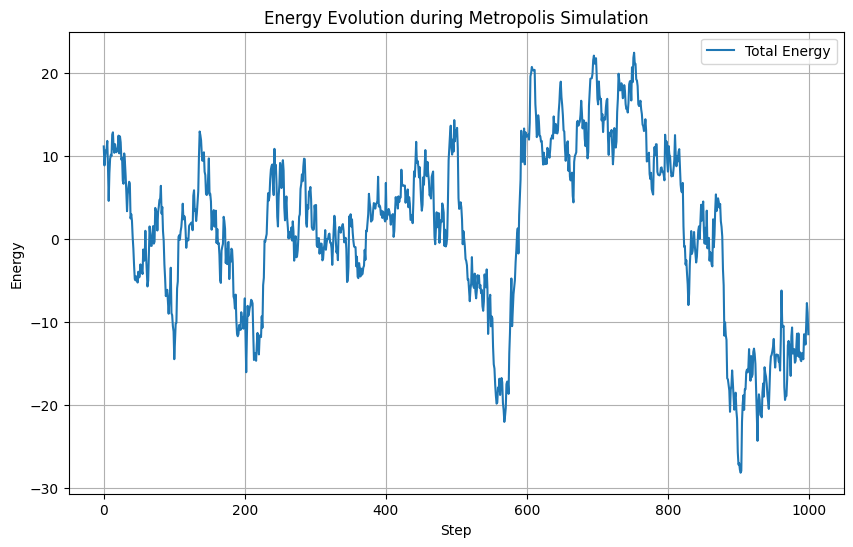

In [10]:
def generate_random_direction():
    """Generate a random unit vector in 3D."""
    theta = np.random.uniform(0, 2 * np.pi)
    phi = np.arccos(np.random.uniform(-1, 1))
    return np.array([np.sin(phi) * np.cos(theta), np.sin(phi) * np.sin(theta), np.cos(phi)])

def metropolis_step(magnetic_moments, L, J=1, D=0.1, B=np.array([0, 0, 1]), mu=1, T=1):
    """
    Perform a single Metropolis step on the lattice of magnetic moments.
    """
    # Pick a random site
    x, y, z = np.random.randint(L), np.random.randint(L), np.random.randint(L)
    old_moment = magnetic_moments[x, y, z]
    
    # Generate a new random orientation
    new_moment = generate_random_direction()
    
    # Compute the energy difference
    old_energy = calculate_local_energy(magnetic_moments, L, x, y, z, J, D, B, mu)
    magnetic_moments[x, y, z] = new_moment  # Temporarily update to new moment
    new_energy = calculate_local_energy(magnetic_moments, L, x, y, z, J, D, B, mu)
    magnetic_moments[x, y, z] = old_moment  # Revert back
    
    delta_E = new_energy - old_energy
    
    # Accept or reject the new orientation
    if delta_E < 0 or np.random.rand() < np.exp(-delta_E / (1 * T)):
        magnetic_moments[x, y, z] = new_moment  # Accept the change
    
    return magnetic_moments, delta_E

def calculate_local_energy(magnetic_moments, L, x, y, z, J, D, B, mu):
    """
    Compute the local energy for a given site in the lattice.
    """
    m_i = magnetic_moments[x, y, z]
    neighbors = [
        ((x + 1) % L, y, z),
        ((x - 1) % L, y, z),
        (x, (y + 1) % L, z),
        (x, (y - 1) % L, z),
        (x, y, (z + 1) % L),
        (x, y, (z - 1) % L),
    ]
    
    # Exchange interaction
    exchange_energy = 0
    dmi_energy = 0
    for xn, yn, zn in neighbors:
        m_j = magnetic_moments[xn, yn, zn]
        exchange_energy += -J * np.dot(m_i, m_j)
        
        # DMI energy (assuming constant D vector for simplicity)
        dmi_energy += D * np.dot(np.cross(m_i, m_j), [1, 1, 1])  # Simplified DMI vector

    # External magnetic field interaction
    field_energy = -mu * np.dot(B, m_i)
    
    return exchange_energy + dmi_energy + field_energy

def calculate_total_energy(magnetic_moments, L, J=1, D=0.1, B=np.array([0, 0, 1]), mu=1):
    """
    Calculate the total energy of the system.
    """
    total_energy = 0
    for x in range(L):
        for y in range(L):
            for z in range(L):
                total_energy += calculate_local_energy(magnetic_moments, L, x, y, z, J, D, B, mu)
    return total_energy / 2  # Divide by 2 to avoid double counting

def run_simulation_with_energy_tracking(L=10, steps=1000, J=1, D=0.1, B=np.array([0, 0, 1]), T=1):
    """
    Run the Metropolis algorithm simulation and track energy evolution.
    """
    # Initialize random magnetic moments
    magnetic_moments = np.array([generate_random_direction() for _ in range(L**3)]).reshape(L, L, L, 3)
    energy_evolution = []
    
    # Perform Metropolis steps
    for step in range(steps):
        magnetic_moments, _ = metropolis_step(magnetic_moments, L, J, D, B, T=T)
        total_energy = calculate_total_energy(magnetic_moments, L, J, D, B)
        energy_evolution.append(total_energy)
    
    return magnetic_moments, energy_evolution

def plot_energy_evolution(energy_evolution):
    """
    Plot the energy evolution during the simulation.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(energy_evolution, label="Total Energy")
    plt.xlabel("Step")
    plt.ylabel("Energy")
    plt.title("Energy Evolution during Metropolis Simulation")
    plt.legend()
    plt.grid()
    plt.show()

# Run the simulation and plot
L = 5  # Lattice size
steps = 1000  # Number of Metropolis steps
magnetic_moments, energy_evolution = run_simulation_with_energy_tracking(L, steps, J=1, D=0.1, B=np.array([0, 0, 1]), T=1)
plot_energy_evolution(energy_evolution)


The graph shows how the system's total energy changes over the course of 1000 steps. The energy fluctuates due to the stochastic nature of the Metropolis algorithm but trends towards lower energy states, indicative of the system's attempt to minimize energy while still allowing thermal fluctuations at a finite temperature 
𝑇
T